# Soil Spectroscopy — Full pipeline (Base, Transfer, Hybrid)

**What this notebook contains:**

- Preprocessing (drop PIDN, remove CO₂ band, spectral transforms)
- Base models: PLS / LightGBM
- Transfer model: Autoencoder pretraining → encoder fine-tune
- Hybrid model: Conv1D + tabular fusion
- 5-fold CV, OOF stacking, MCRMSE evaluation, plots

**How to use:** Upload `train.csv` and `test.csv` in the notebook environment (Colab: left pane Upload; Kaggle: use `/kaggle/input/...`).


In [ ]:

print("If running in Colab, ensure packages are installed. On Kaggle skip this step.")

If running in Colab, ensure packages are installed. On Kaggle skip this step.


In [ ]:
import os, math, random, gc, json
import numpy as np, pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
print('Imports done. TensorFlow version:', tf.__version__)

Imports done. TensorFlow version: 2.19.0


## 1) Load data

Place `train.csv` and `test.csv` in the working directory. If using Kaggle, set paths to the input dataset. If using Colab, upload files to the left pane.


In [ ]:

TRAIN_CSV = 'training.csv'
TEST_CSV  = 'sorted_test.csv'


if not os.path.exists(TRAIN_CSV) and os.path.exists('/kaggle/input/'):

    for root, dirs, files in os.walk('/kaggle/input'):
        for f in files:
            if f.lower().startswith('train') and f.lower().endswith('.csv'):
                TRAIN_CSV = os.path.join(root, f)
            if f.lower().startswith('test') and f.lower().endswith('.csv'):
                TEST_CSV = os.path.join(root, f)

print('TRAIN_CSV=', TRAIN_CSV)
print('TEST_CSV=', TEST_CSV)

train = pd.read_csv(TRAIN_CSV)
print('Loaded train shape:', train.shape)
train.head(3)

TRAIN_CSV= training.csv
TEST_CSV= sorted_test.csv
Loaded train shape: (1157, 3600)


,PIDN,m7497.96,m7496.04,m7494.11,m7492.18,m7490.25,m7488.32,m7486.39,m7484.46,m7482.54,...,REF7,RELI,TMAP,TMFI,Depth,Ca,P,pH,SOC,Sand
0,XNhoFZW5,0.302553,0.301137,0.299748,0.300354,0.302679,0.303799,0.301702,0.298936,0.298126,...,-0.646673,1.687734,0.190708,0.056843,Topsoil,-0.295749,-0.041336,-1.129366,0.353258,1.269748
1,9XNspFTd,0.270192,0.268555,0.266964,0.267938,0.271013,0.272346,0.269870,0.266976,0.266544,...,-0.646673,1.687734,0.190708,0.056843,Subsoil,-0.387442,-0.231552,-1.531538,-0.264023,1.692209
2,WDId41qG,0.317433,0.316265,0.314948,0.315224,0.316942,0.317764,0.316067,0.313874,0.313301,...,-0.814516,1.806660,0.190708,0.056843,Topsoil,-0.248601,-0.224635,-0.259551,0.064152,2.091835


In [ ]:
# Define columns and clean
TARGETS = ['SOC','pH','Ca','P','Sand']
ID_COLS = ['PIDN']

spec_cols = [c for c in train.columns if c.startswith('m')]
print('Total spectral cols:', len(spec_cols))

# Remove CO2 band columns between 2352.76 and 2379.76 cm^-1
def mval(c):
    try:
        return float(c[1:])
    except:
        return None

co2_min, co2_max = 2352.76, 2379.76
co2_cols = [c for c in spec_cols if (mval(c) is not None and co2_min <= mval(c) <= co2_max)]
print('CO2 cols count:', len(co2_cols))
spec_cols_clean = [c for c in spec_cols if c not in co2_cols]
print('Spectral cols after CO2 removal:', len(spec_cols_clean))

# Tabular cols (everything not spectral, not target, not id)
tab_cols = [c for c in train.columns if c not in spec_cols + TARGETS + ID_COLS]
print('Tabular cols:', tab_cols)

Total spectral cols: 3578
CO2 cols count: 15
Spectral cols after CO2 removal: 3563
Tabular cols: ['BSAN', 'BSAS', 'BSAV', 'CTI', 'ELEV', 'EVI', 'LSTD', 'LSTN', 'REF1', 'REF2', 'REF3', 'REF7', 'RELI', 'TMAP', 'TMFI', 'Depth']


In [ ]:
# Preprocessing helpers: SG smoothing, SNV, PCA helper
from scipy.signal import savgol_filter

def apply_savgol(X, window=11, poly=2, deriv=0):
    # X: (n_samples, n_timesteps)
    return savgol_filter(X, window_length=window, polyorder=poly, deriv=deriv, axis=1, mode='mirror')

def snv(X):
    # Standard Normal Variate per sample
    mu = X.mean(axis=1, keepdims=True)
    sigma = X.std(axis=1, keepdims=True)
    return (X - mu) / (sigma + 1e-12)

def mcrmse(y_true, y_pred):
    se = ((y_true - y_pred)**2).mean(axis=0)
    rmse = np.sqrt(se)
    return float(rmse.mean()), rmse

print('Helpers ready')

Helpers ready


In [ ]:
# Prepare arrays
# Drop PIDN if exists
if 'PIDN' in train.columns:
    train = train.drop(columns=['PIDN'])

X_spec = train[spec_cols_clean].values.astype(np.float32)
X_tab  = train[tab_cols].copy()
if 'Depth' in X_tab.columns:
    X_tab['Depth_enc'] = LabelEncoder().fit_transform(X_tab['Depth'])
    X_tab = X_tab.drop(columns=['Depth'])

X_tab = X_tab.values.astype(np.float32)
y = train[TARGETS].values.astype(np.float32)

print('Shapes: X_spec, X_tab, y ->', X_spec.shape, X_tab.shape, y.shape)

# Optional transforms: SG smoothing and SNV (toggle)
APPLY_SG = True
SG_WINDOW=11; SG_POLY=2; SG_DERIV=0
APPLY_SNV = False

if APPLY_SG:
    print('Applying Savitzky-Golay...')
    X_spec = apply_savgol(X_spec, window=SG_WINDOW, poly=SG_POLY, deriv=SG_DERIV)
if APPLY_SNV:
    print('Applying SNV...')
    X_spec = snv(X_spec)

# Scale spectral and tabular separately
spec_scaler = StandardScaler().fit(X_spec)
X_spec_s = spec_scaler.transform(X_spec)
tab_scaler  = StandardScaler().fit(X_tab)
X_tab_s = tab_scaler.transform(X_tab)

# For CNN input reshape
X_spec_cnn = X_spec_s[..., np.newaxis]  # shape (n, timesteps, 1)

print('Prepared: X_spec_s shape, X_tab_s shape ->', X_spec_s.shape, X_tab_s.shape)

Shapes: X_spec, X_tab, y -> (1157, 3563) (1157, 16) (1157, 5)
Applying Savitzky-Golay...
Prepared: X_spec_s shape, X_tab_s shape -> (1157, 3563) (1157, 16)


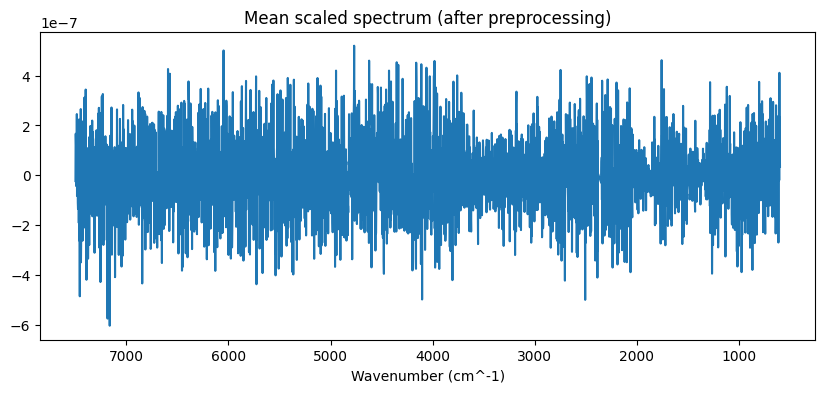

In [ ]:

import matplotlib.pyplot as plt
wavenums = [mval(c) for c in spec_cols_clean]
plt.figure(figsize=(10,4))
plt.plot(wavenums, X_spec_s.mean(axis=0))
plt.gca().invert_xaxis()
plt.title('Mean scaled spectrum (after preprocessing)')
plt.xlabel('Wavenumber (cm^-1)')
plt.show()

In [ ]:
import os, math, random, gc, json
import numpy as np, pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
print('Imports done. TensorFlow version:', tf.__version__)

# Base models: PLS (multioutput) and LightGBM on PCA features
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=42)

# PCA for tree models
N_PCS = 60
pca = PCA(n_components=N_PCS, random_state=42).fit(X_spec_s)
X_pca = pca.transform(X_spec_s)
print('PCA explained variance sum:', pca.explained_variance_ratio_.sum())

# Combine features for tree models
spec_stats = np.vstack([X_spec_s.mean(axis=1), X_spec_s.std(axis=1)]).T
X_tree = np.hstack([X_pca, spec_stats, X_tab_s])

oof_pls = np.zeros_like(y); oof_lgb = np.zeros_like(y)
test_preds_lgb = None

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_tree)):
    print('\nFold', fold+1)
    # PLS on spectra+tabular (simple baseline)
    pls = PLSRegression(n_components=30)
    pls.fit(np.hstack([X_spec_s[tr_idx], X_tab_s[tr_idx]]), y[tr_idx])
    oof_pls[val_idx] = pls.predict(np.hstack([X_spec_s[val_idx], X_tab_s[val_idx]]))
    # LightGBM per target
    for t_i, tname in enumerate(TARGETS):
        tr_X = X_tree[tr_idx]; tr_y = y[tr_idx, t_i]
        val_X = X_tree[val_idx]
        lgb_train = lgb.Dataset(tr_X, tr_y)
        lgb_val = lgb.Dataset(X_tree[val_idx], y[val_idx, t_i], reference=lgb_train)
        params = {'objective':'regression','metric':'rmse','verbosity':-1,
                  'learning_rate':0.05,'num_leaves':31,'seed':42,'feature_fraction':0.8,'bagging_fraction':0.8,'bagging_freq':5}
        callbacks = [lgb.early_stopping(100, verbose=100)] # Use lgb.early_stopping callback
        model = lgb.train(params, lgb_train, num_boost_round=2000, valid_sets=[lgb_val], callbacks=callbacks)
        oof_lgb[val_idx, t_i] = model.predict(val_X, num_iteration=model.best_iteration)

    gc.collect()

print('\nPLS OOF MCRMSE:', mcrmse(y, oof_pls)[0])
print('LGB OOF MCRMSE:', mcrmse(y, oof_lgb)[0])

Imports done. TensorFlow version: 2.19.0
PCA explained variance sum: 0.9999564

Fold 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's rmse: 0.363433
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	valid_0's rmse: 0.413544
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[685]	valid_0's rmse: 0.564748
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	valid_0's rmse: 0.643059
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[260]	valid_0's rmse: 0.329998

Fold 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[932]	valid_0's rmse: 0.315844
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[709]	valid_0's rmse: 0.371733
Training 

In [ ]:
def build_base_mlp(input_shape, n_targets):
    inp = layers.Input(shape=input_shape)
    x = layers.Flatten()(inp) # Flatten if input is 3D
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(n_targets, activation='linear')(x)
    model = models.Model(inp, out, name='Base_MLP')
    model.compile(optimizer='adam', loss='mse', metrics=[keras_mcrmse])
    return model

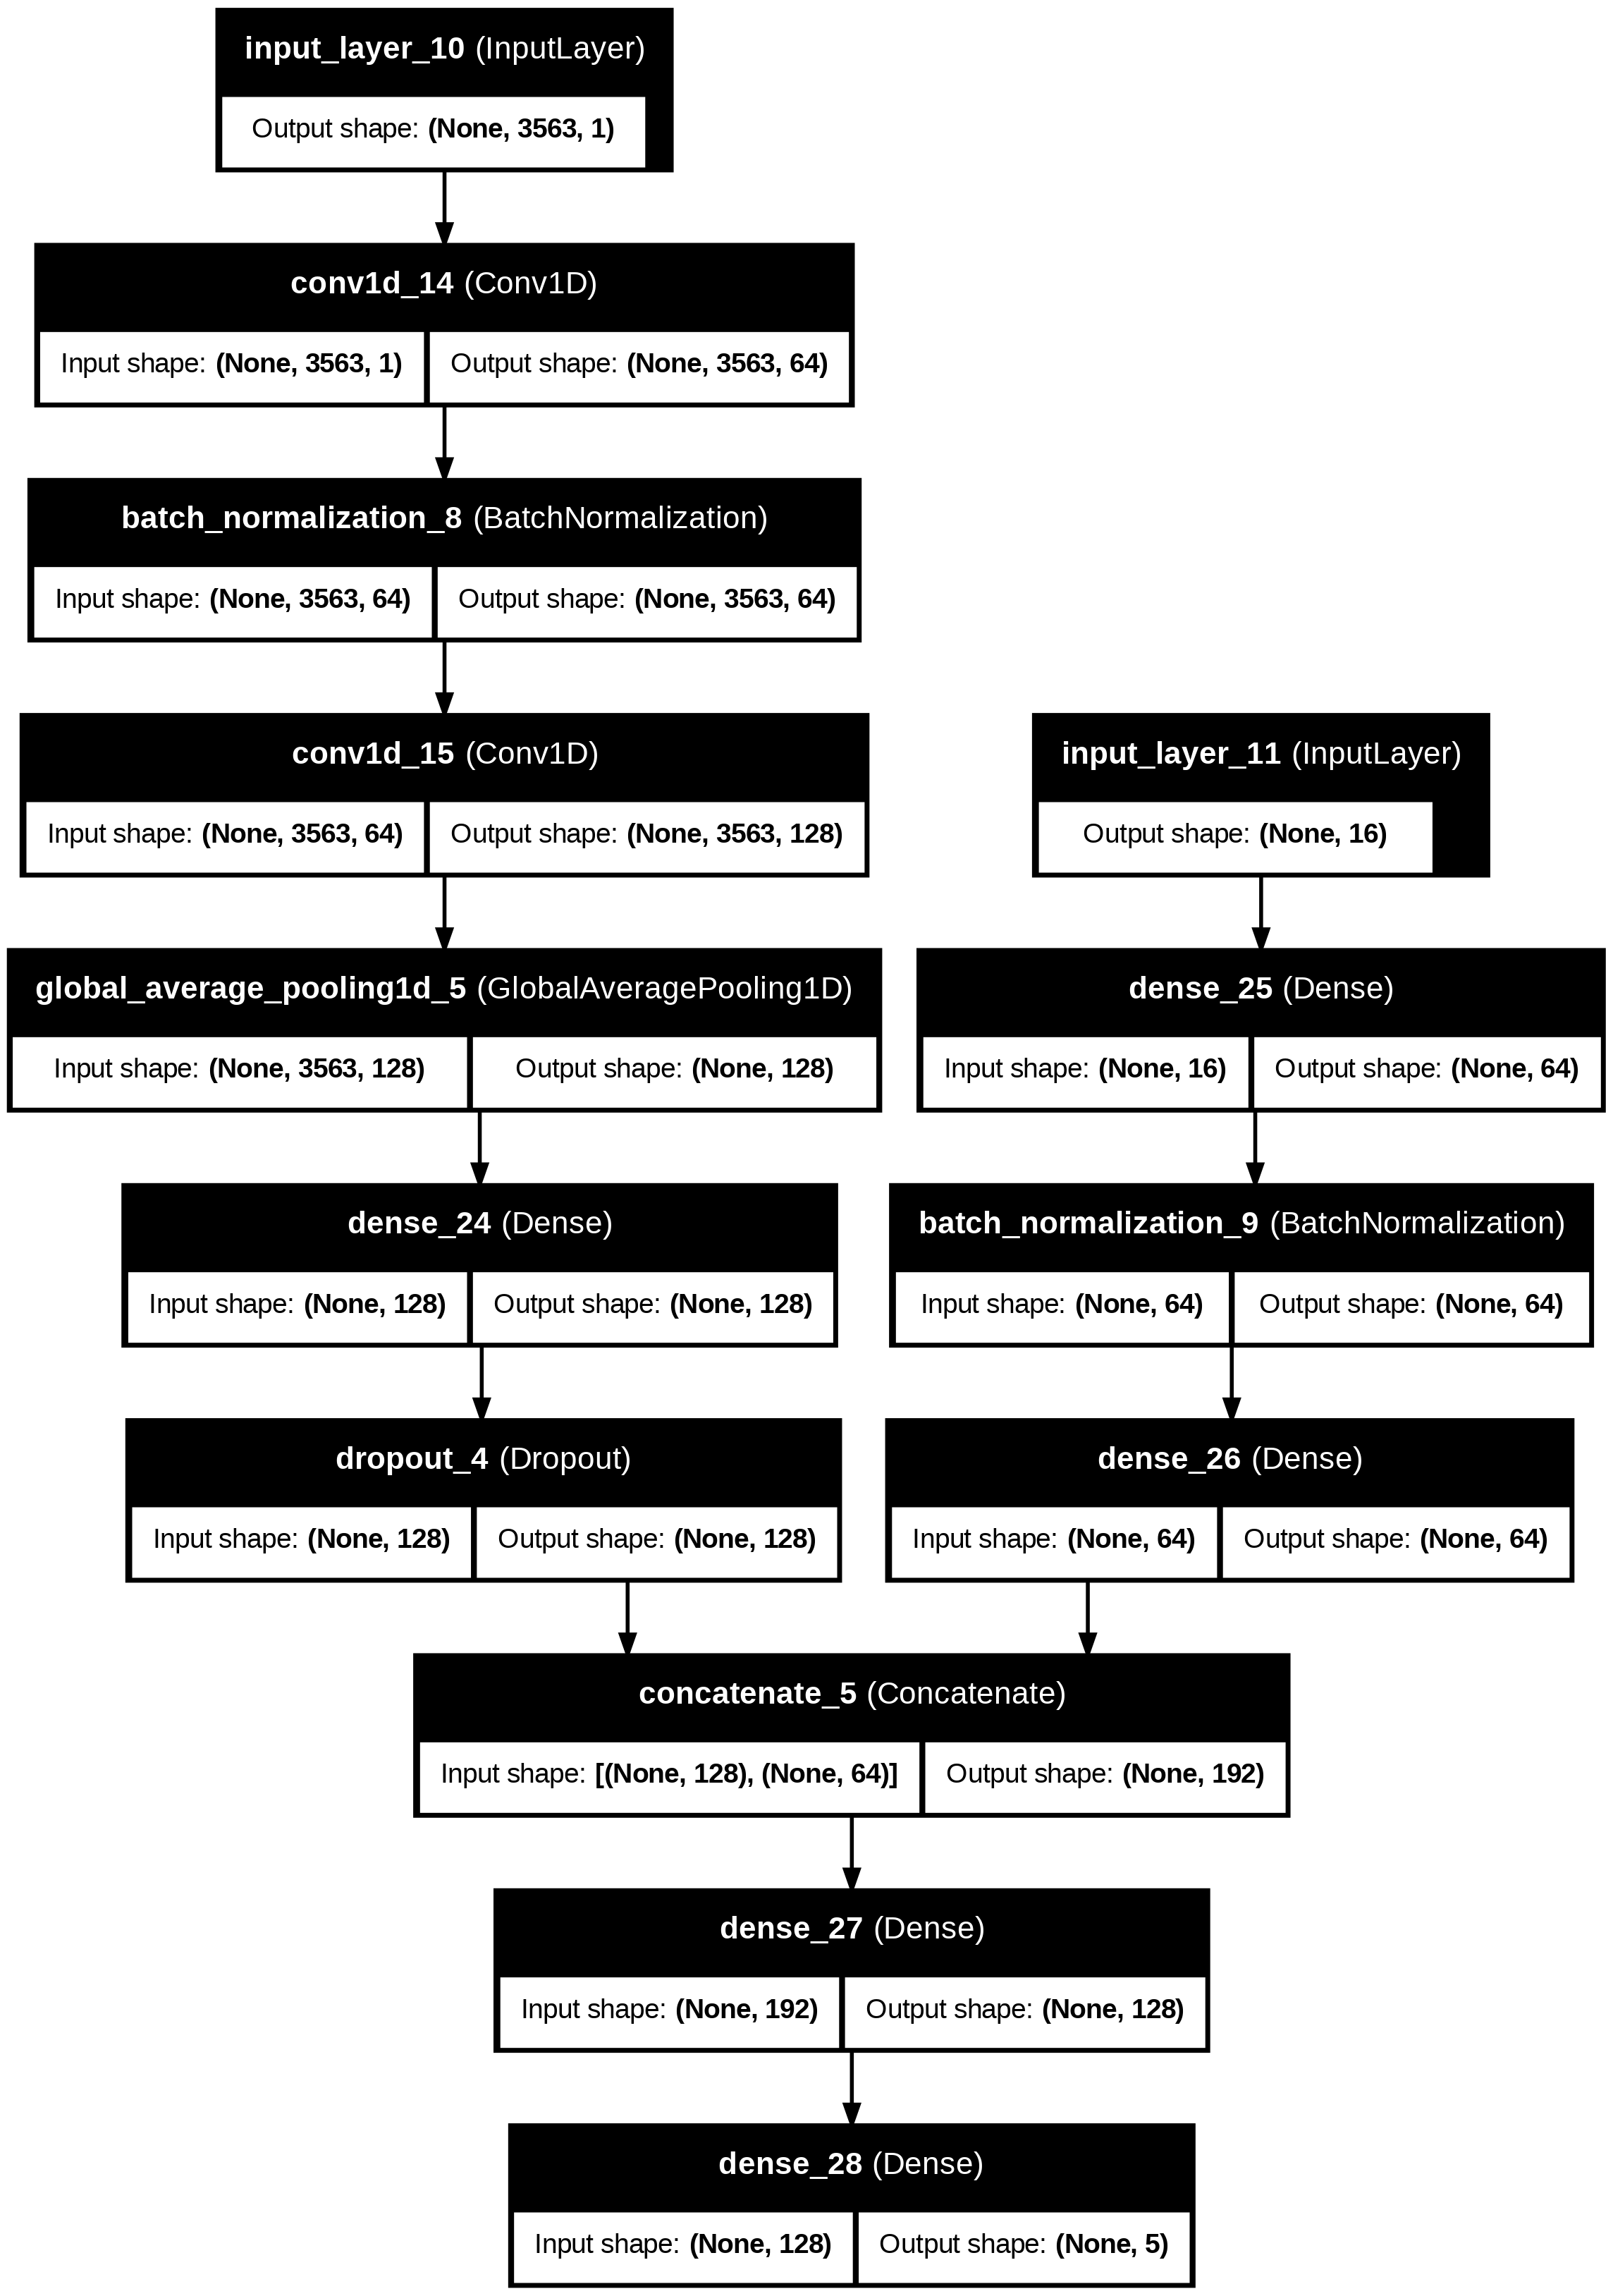

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='hybrid_model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Transfer model: simple autoencoder pretraining on spectra, then use encoder
tf.random.set_seed(42)
input_shape = X_spec_cnn.shape[1:]  # (timesteps, 1)

def build_autoencoder(input_shape, latent_dim=128):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, 5, padding='same', activation='relu')(inp)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)
    # Capture shape before GlobalAveragePooling1D
    x_before_global_avg_pooling = x
    x = layers.GlobalAveragePooling1D()(x)
    z = layers.Dense(latent_dim, activation='relu', name='latent')(x)

    # decoder to reconstruct the original input shape
    # Based on the encoder path: (N, 3563, 1) -> ... -> (N, 891, 256) -> GlobalAveragePooling -> (N, 256)
    # We need to reverse from latent_dim back to (N, 3563, 1)

    # First, map latent_dim back to the flattened representation before GlobalAveragePooling
    # Use the captured shape from x_before_global_avg_pooling
    timesteps_from_encoder = K.int_shape(x_before_global_avg_pooling)[1]
    features_from_encoder = K.int_shape(x_before_global_avg_pooling)[2]

    x2 = layers.Dense(timesteps_from_encoder * features_from_encoder, activation='relu')(z)
    x2 = layers.Reshape((timesteps_from_encoder, features_from_encoder))(x2) # Reshape back to (None, 891, 256)

    # Reverse the upsampling and convolution operations
    x2 = layers.UpSampling1D(2)(x2) # (None, 1782, 256)
    x2 = layers.Conv1D(128, 5, padding='same', activation='relu')(x2) # (None, 1782, 128)
    x2 = layers.UpSampling1D(2)(x2) # (None, 3564, 128) - Note: this is 3564, not 3563
    x2 = layers.Conv1D(64, 5, padding='same', activation='relu')(x2) # (None, 3564, 64)
    out = layers.Conv1D(1, 3, padding='same', activation='linear')(x2) # (None, 3564, 1)

    # Crop the output to exactly match the input sequence length (3563)
    output_length = input_shape[0] # 3563
    current_length = K.int_shape(out)[1] # 3564
    if current_length > output_length:
        # Crop from the end to match the original input length
        out = layers.Cropping1D(cropping=(0, current_length - output_length))(out)

    ae = models.Model(inp, out, name='autoencoder')
    ae.compile(optimizer='adam', loss='mse')
    return ae

print('Building autoencoder...')
ae = build_autoencoder(input_shape, latent_dim=128)
ae.summary()

# Pretrain autoencoder quickly (for demo; increase epochs in real runs)
es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
ae.fit(X_spec_cnn, X_spec_cnn, epochs=10, batch_size=32, callbacks=[es], verbose=2)

# Extract encoder part
encoder = models.Model(ae.input, ae.get_layer('latent').output)
enc_feats = encoder.predict(X_spec_cnn)
print('Encoder features shape:', enc_feats.shape)

# Define a Keras-compatible MCRMSE metric that returns a single scalar tensor
def keras_mcrmse(y_true, y_pred):
    se = K.square(y_true - y_pred)
    rmse_per_output = K.sqrt(K.mean(se, axis=0))
    return K.mean(rmse_per_output)

# Fine-tune: build a small regressor on top of encoder + tabular
def build_transfer_regressor(encoder, tab_dim, n_targets):
    for layer in encoder.layers: layer.trainable = True  # allow fine-tuning
    spec_in = encoder.input
    spec_feat = encoder.output
    tab_in = layers.Input(shape=(tab_dim,))
    t = layers.Dense(64, activation='relu')(tab_in)
    merged = layers.concatenate([spec_feat, t])
    h = layers.Dense(128, activation='relu')(merged)
    out = layers.Dense(n_targets, activation='linear')(h)
    model = models.Model([spec_in, tab_in], out)
    model.compile(optimizer='adam', loss='mse', metrics=[keras_mcrmse])
    return model

transfer_model = build_transfer_regressor(encoder, X_tab_s.shape[1], len(TARGETS))
transfer_model.summary()

# Quick train (use CV for real training)
transfer_model.fit([X_spec_cnn, X_tab_s], y, epochs=20, batch_size=32, verbose=2)

Building autoencoder...


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3563, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3563, 64)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1782, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1782, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 891, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 891, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 228096)         │    29,424,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 891, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 1782, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1782, 128)      │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 3564, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 3564, 64)       │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 3564, 1)        │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d (Cropping1D)         │ (None, 3563, 1)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,802,497 (113.69 MB)

 Trainable params: 29,802,497 (113.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
37/37 - 14s - 385ms/step - loss: 0.5110
Epoch 2/10
37/37 - 3s - 71ms/step - loss: 0.2473
Epoch 3/10
37/37 - 3s - 69ms/step - loss: 0.2359
Epoch 4/10
37/37 - 3s - 69ms/step - loss: 0.2318
Epoch 5/10
37/37 - 5s - 140ms/step - loss: 0.2282
Epoch 6/10
37/37 - 3s - 69ms/step - loss: 0.2196
Epoch 7/10
37/37 - 3s - 68ms/step - loss: 0.2123
Epoch 8/10
37/37 - 3s - 69ms/step - loss: 0.2093
Epoch 9/10
37/37 - 3s - 69ms/step - loss: 0.2043
Epoch 10/10
37/37 - 5s - 141ms/step - loss: 0.2021
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Encoder features shape: (1157, 128)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3563, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 3563, 64)  │        384 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1782, 64)  │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1782, 128) │     41,088 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 891, 128)  │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 891, 256)  │     98,560 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ conv1d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent (Dense)      │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      1,088 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ latent[0][0],     │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     24,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │        645 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 199,365 (778.77 KB)

 Trainable params: 199,365 (778.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
37/37 - 7s - 187ms/step - keras_mcrmse: 0.8272 - loss: 0.8068
Epoch 2/20
37/37 - 1s - 29ms/step - keras_mcrmse: 0.7233 - loss: 0.6271
Epoch 3/20
37/37 - 1s - 29ms/step - keras_mcrmse: 0.6774 - loss: 0.5555
Epoch 4/20
37/37 - 1s - 30ms/step - keras_mcrmse: 0.6478 - loss: 0.5109
Epoch 5/20
37/37 - 1s - 29ms/step - keras_mcrmse: 0.6222 - loss: 0.4760
Epoch 6/20
37/37 - 1s - 29ms/step - keras_mcrmse: 0.6021 - loss: 0.4491
Epoch 7/20
37/37 - 1s - 31ms/step - keras_mcrmse: 0.5857 - loss: 0.4271
Epoch 8/20
37/37 - 1s - 31ms/step - keras_mcrmse: 0.5721 - loss: 0.4103
Epoch 9/20
37/37 - 1s - 29ms/step - keras_mcrmse: 0.5618 - loss: 0.3976
Epoch 10/20
37/37 - 1s - 29ms/step - keras_mcrmse: 0.5515 - loss: 0.3862
Epoch 11/20
37/37 - 1s - 29ms/step - keras_mcrmse: 0.5444 - loss: 0.3771
Epoch 12/20
37/37 - 1s - 29ms/step - keras_mcrmse: 0.5372 - loss: 0.3692
Epoch 13/20
37/37 - 1s - 29ms/step - keras_mcrmse: 0.5293 - loss: 0.3604
Epoch 14/20
37/37 - 1s - 29ms/step - keras_mcrmse: 0.5241 -

In [ ]:
# Hybrid Conv1D + tabular model with CV (simple demonstration)
def build_hybrid(spec_shape, tab_dim, dropout=0.2):
    spec_in = layers.Input(shape=spec_shape)
    x = layers.Conv1D(64, 5, padding='same', activation='relu')(spec_in)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout)(x)

    tab_in = layers.Input(shape=(tab_dim,))
    t = layers.Dense(64, activation='relu')(tab_in)
    t = layers.BatchNormalization()(t)
    t = layers.Dense(64, activation='relu')(t)

    merged = layers.concatenate([x,t])
    h = layers.Dense(128, activation='relu')(merged)
    out = layers.Dense(len(TARGETS), activation='linear')(h)
    model = models.Model([spec_in, tab_in], out)
    model.compile(optimizer='adam', loss='mse', metrics=[keras_mcrmse])
    return model

# 5-fold CV training for hybrid
oof_hybrid = np.zeros_like(y)
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_spec_cnn)):
    print('\nHybrid Fold', fold+1)
    model = build_hybrid(X_spec_cnn.shape[1:], X_tab_s.shape[1], dropout=0.25)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit([X_spec_cnn[tr_idx], X_tab_s[tr_idx]], y[tr_idx],
              validation_data=([X_spec_cnn[val_idx], X_tab_s[val_idx]], y[val_idx]),
              epochs=80, batch_size=32, callbacks=[es], verbose=2)
    oof_hybrid[val_idx] = model.predict([X_spec_cnn[val_idx], X_tab_s[val_idx]])

print('Hybrid OOF MCRMSE:', mcrmse(y, oof_hybrid)[0])


Hybrid Fold 1
Epoch 1/80
29/29 - 12s - 409ms/step - keras_mcrmse: 0.8680 - loss: 0.8792 - val_keras_mcrmse: 0.8824 - val_loss: 1.0372
Epoch 2/80
29/29 - 1s - 29ms/step - keras_mcrmse: 0.7495 - loss: 0.6690 - val_keras_mcrmse: 0.8443 - val_loss: 0.9392
Epoch 3/80
29/29 - 1s - 29ms/step - keras_mcrmse: 0.7049 - loss: 0.5981 - val_keras_mcrmse: 0.8187 - val_loss: 0.8802
Epoch 4/80
29/29 - 1s - 29ms/step - keras_mcrmse: 0.6676 - loss: 0.5426 - val_keras_mcrmse: 0.7913 - val_loss: 0.8221
Epoch 5/80
29/29 - 1s - 29ms/step - keras_mcrmse: 0.6387 - loss: 0.5017 - val_keras_mcrmse: 0.7646 - val_loss: 0.7606
Epoch 6/80
29/29 - 1s - 29ms/step - keras_mcrmse: 0.6195 - loss: 0.4720 - val_keras_mcrmse: 0.7488 - val_loss: 0.7281
Epoch 7/80
29/29 - 1s - 29ms/step - keras_mcrmse: 0.5988 - loss: 0.4432 - val_keras_mcrmse: 0.7316 - val_loss: 0.6930
Epoch 8/80
29/29 - 1s - 29ms/step - keras_mcrmse: 0.5872 - loss: 0.4251 - val_keras_mcrmse: 0.7136 - val_loss: 0.6572
Epoch 9/80
29/29 - 1s - 29ms/step - ker

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

Hybrid Fold 3
Epoch 1/80
29/29 - 11s - 379ms/step - keras_mcrmse: 0.8779 - loss: 0.8808 - val_keras_mcrmse: 0.7582 - val_loss: 0.6779
Epoch 2/80
29/29 - 1s - 30ms/step - keras_mcrmse: 0.7372 - loss: 0.6361 - val_keras_mcrmse: 0.7312 - val_loss: 0.6269
Epoch 3/80
29/29 - 1s - 30ms/step - keras_mcrmse: 0.6787 - loss: 0.5423 - val_keras_mcrmse: 0.7085 - val_loss: 0.5907
Epoch 4/80
29/29 - 1s - 30ms/step - keras_mcrmse: 0.6454 - loss: 0.4909 - val_keras_mcrmse: 0.6869 - val_loss: 0.5597
Epoch 5/80
29/29 - 1s - 30ms/step - keras_mcrmse: 0.6231 - loss: 0.4574 - val_keras_mcrmse: 0.6702 - val_loss: 0.5357
Epoch 6/80
29/29 - 1s - 29ms/step - keras_mcrmse: 0.6055 - loss: 0.4328 - val_keras_mcrmse: 0.6535 - val_loss: 0.5134
Epoch 7/80
29/29 - 1s - 29ms/step - keras_mcrmse: 0.5873 - loss: 0.4075 - val_keras_mcrmse: 0.6406 - val_loss: 0.4955
Epoch 8/80
29/29 - 1s - 29ms/step - keras_mcrmse: 0.5729 - loss: 0.3870 - val_keras_mcrmse: 0.6333 - val_loss: 0.4871
E

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

Hybrid Fold 4
Epoch 1/80
29/29 - 9s - 320ms/step - keras_mcrmse: 0.8906 - loss: 0.9164 - val_keras_mcrmse: 0.8290 - val_loss: 0.8851
Epoch 2/80
29/29 - 1s - 33ms/step - keras_mcrmse: 0.7495 - loss: 0.6658 - val_keras_mcrmse: 0.7917 - val_loss: 0.8093
Epoch 3/80
29/29 - 1s - 30ms/step - keras_mcrmse: 0.6884 - loss: 0.5678 - val_keras_mcrmse: 0.7560 - val_loss: 0.7491
Epoch 4/80
29/29 - 1s - 30ms/step - keras_mcrmse: 0.6510 - loss: 0.5104 - val_keras_mcrmse: 0.7312 - val_loss: 0.7097
Epoch 5/80
29/29 - 1s - 30ms/step - keras_mcrmse: 0.6214 - loss: 0.4640 - val_keras_mcrmse: 0.7081 - val_loss: 0.6804
Epoch 6/80
29/29 - 1s - 31ms/step - keras_mcrmse: 0.6021 - loss: 0.4391 - val_keras_mcrmse: 0.6942 - val_loss: 0.6636
Epoch 7/80
29/29 - 1s - 35ms/step - keras_mcrmse: 0.5842 - loss: 0.4135 - val_keras_mcrmse: 0.6777 - val_loss: 0.6383
Epoch 8/80
29/29 - 1s - 32ms/step - keras_mcrmse: 0.5693 - loss: 0.3953 - val_keras_mcrmse: 0.6686 - val_loss: 0.6284
Ep

In [ ]:
# Simple stacking: use OOFs from PLS, LGB, and Hybrid (we have oof_pls, oof_lgb, oof_hybrid)
# Ensure shapes are correct
print('Shapes:', oof_pls.shape, oof_lgb.shape, oof_hybrid.shape)

stack_features = np.hstack([oof_pls, oof_lgb, oof_hybrid])
print('Stack features shape:', stack_features.shape)

# Train meta-learner (Ridge multioutput)
meta = Ridge(alpha=1.0)
meta.fit(stack_features, y)
stack_pred = meta.predict(stack_features)
print('Stacked (train) MCRMSE:', mcrmse(y, stack_pred)[0])

Shapes: (1157, 5) (1157, 5) (1157, 5)
Stack features shape: (1157, 15)
Stacked (train) MCRMSE: 0.4372285008430481


In [ ]:
# Evaluate per-target RMSE for each model type
for name, preds in [('PLS', oof_pls), ('LGB', oof_lgb), ('Hybrid', oof_hybrid), ('Stack', stack_pred)]:
    mcrm, per_rmse = mcrmse(y, preds)
    print(f'{name}: MCRMSE={mcrm:.5f} | per-target RMSE: {dict(zip(TARGETS, np.round(per_rmse,4)))}')

PLS: MCRMSE=0.50016 | per-target RMSE: {'SOC': np.float32(0.3897), 'pH': np.float32(0.4113), 'Ca': np.float32(0.379), 'P': np.float32(0.9361), 'Sand': np.float32(0.3847)}
LGB: MCRMSE=0.47179 | per-target RMSE: {'SOC': np.float32(0.3919), 'pH': np.float32(0.3847), 'Ca': np.float32(0.3862), 'P': np.float32(0.8434), 'Sand': np.float32(0.3528)}
Hybrid: MCRMSE=0.68338 | per-target RMSE: {'SOC': np.float32(0.721), 'pH': np.float32(0.5693), 'Ca': np.float32(0.6195), 'P': np.float32(0.9778), 'Sand': np.float32(0.5292)}
Stack: MCRMSE=0.43723 | per-target RMSE: {'SOC': np.float32(0.3339), 'pH': np.float32(0.3577), 'Ca': np.float32(0.3436), 'P': np.float32(0.8205), 'Sand': np.float32(0.3305)}


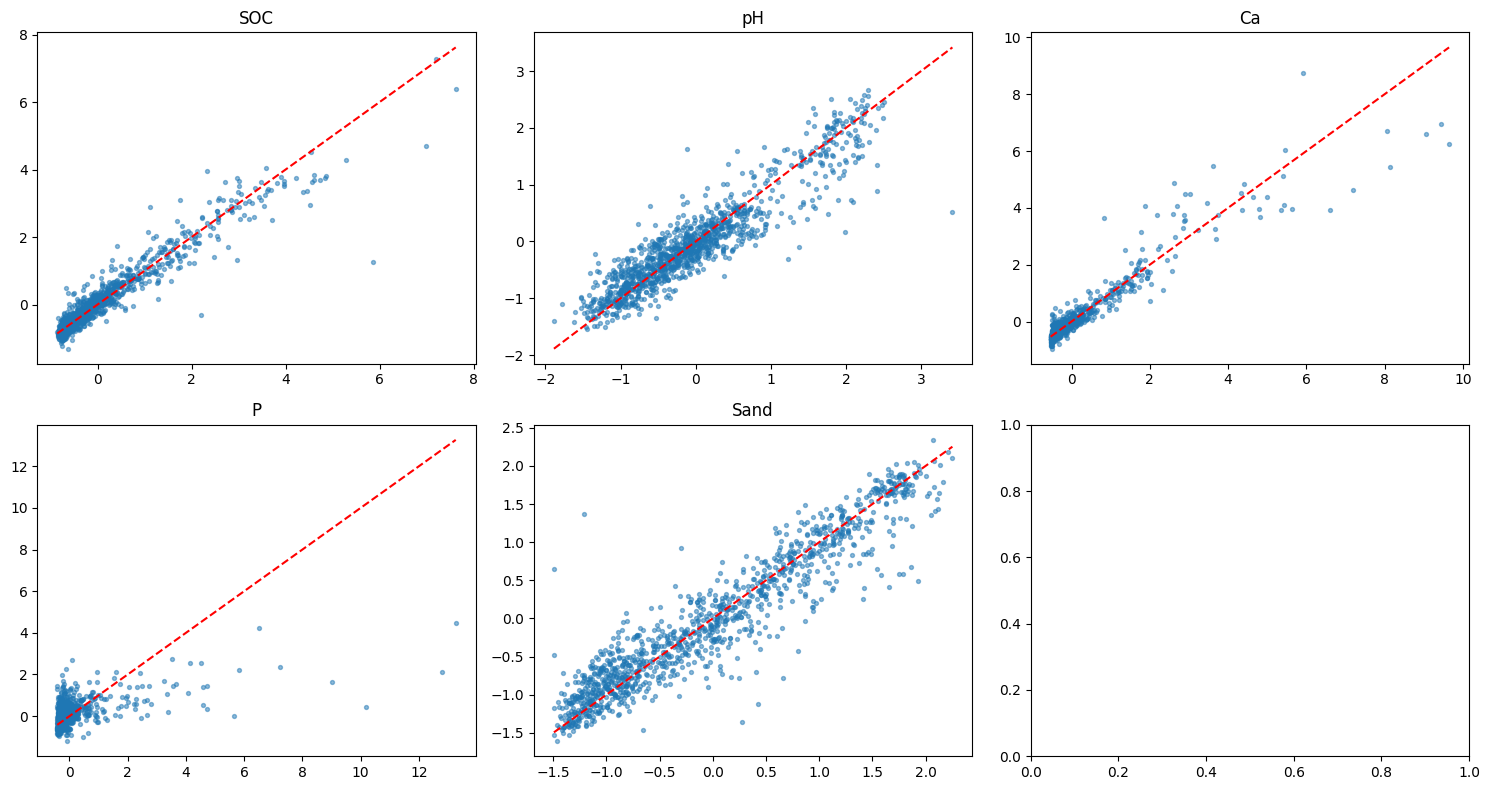

In [ ]:
# Plot predicted vs actual for each target (stack)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,3, figsize=(15,8))
axs = axs.flatten()
for i, t in enumerate(TARGETS):
    axs[i].scatter(y[:,i], stack_pred[:,i], alpha=0.5, s=8)
    axs[i].plot([y[:,i].min(), y[:,i].max()],[y[:,i].min(), y[:,i].max()], 'r--')
    axs[i].set_title(t)
plt.tight_layout()
plt.show()